(Euler-Maruyama_and_SDEs)=
# Inferring parameters of SDEs using a Euler-Maruyama scheme

:::{post} July 2016
:tags: time series
:category: advanced, reference
:author: @maedoc
:::

_This notebook is derived from a presentation prepared for the Theoretical Neuroscience Group, Institute of Systems Neuroscience at Aix-Marseile University._

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy as sp

# Ignore UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Example Model

Here's a scalar linear SDE in symbolic form

$ dX_t = \lambda X_t + \sigma^2 dW_t $

discretized with the Euler-Maruyama scheme. 

We can simulate data from this process and then attempt to recover the parameters.

In [3]:
# parameters
lam = -0.78
s2 = 5e-3
N = 200
dt = 1e-1

# time series
x = 0.1
x_t = []

# simulate
for i in range(N):
    x += dt * lam * x + np.sqrt(dt) * s2 * np.random.randn()
    x_t.append(x)

x_t = np.array(x_t)

# z_t noisy observation
z_t = x_t + np.random.randn(x_t.size) * 5e-3

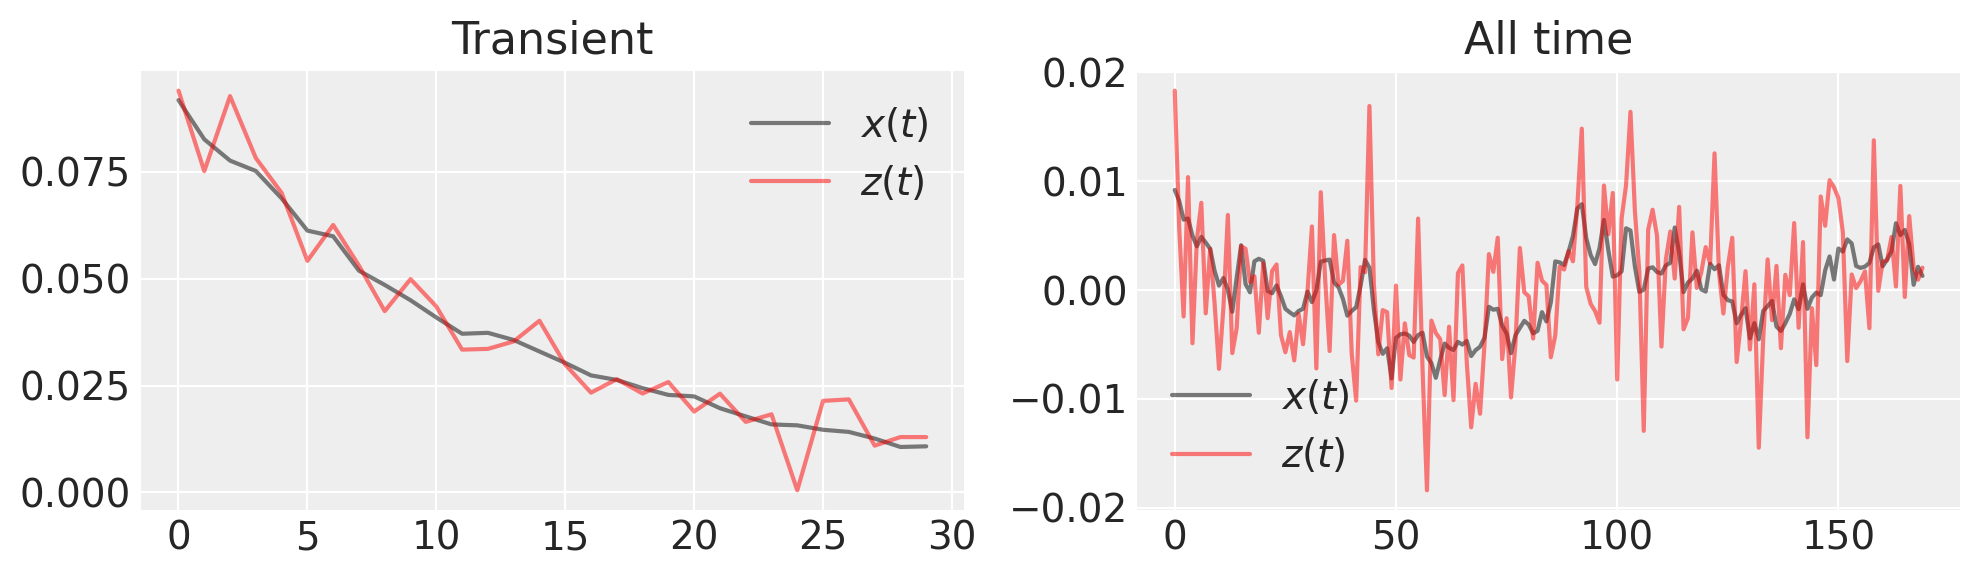

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x_t[:30], "k", label="$x(t)$", alpha=0.5)
ax1.plot(z_t[:30], "r", label="$z(t)$", alpha=0.5)
ax1.set_title("Transient")
ax1.legend()

ax2.plot(x_t[30:], "k", label="$x(t)$", alpha=0.5)
ax2.plot(z_t[30:], "r", label="$z(t)$", alpha=0.5)
ax2.set_title("All time")
ax2.legend()

plt.tight_layout()

What is the inference we want to make? Since we've made a noisy observation of the generated time series, we need to estimate both $x(t)$ and $\lambda$.

We need to provide an SDE function that returns the drift and diffusion coefficients.

In [5]:
def lin_sde(x, lam, s2):
    return lam * x, s2

The probability model is comprised of a prior on the drift parameter `lam`, the diffusion coefficient `s`, the latent Euler-Maruyama process `xh` and the likelihood describing the noisy observations `zh`. We will assume that we know the observation noise.

In [6]:
with pm.Model() as model:
    # uniform prior, but we know it must be negative
    l = pm.HalfCauchy("l", beta=1)
    s = pm.Uniform("s", 0.005, 0.5)

    # "hidden states" following a linear SDE distribution
    # parametrized by time step (det. variable) and lam (random variable)
    xh = pm.EulerMaruyama("xh", dt=dt, sde_fn=lin_sde, sde_pars=(-l, s**2), shape=N, initval=x_t)

    # predicted observation
    zh = pm.Normal("zh", mu=xh, sigma=5e-3, observed=z_t)

Once the model is constructed, we perform inference, which here is via the NUTS algorithm as implemented in `nutpie`, which will be extremely fast.

In [7]:
with model:
    trace = pm.sample(nuts_sampler="nutpie", random_seed=RANDOM_SEED, target_accept=0.99)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.06,255
,2000,0,0.06,127
,2000,0,0.07,255
,2000,0,0.06,191


Next, we plot some basic statistics on the samples from the posterior,

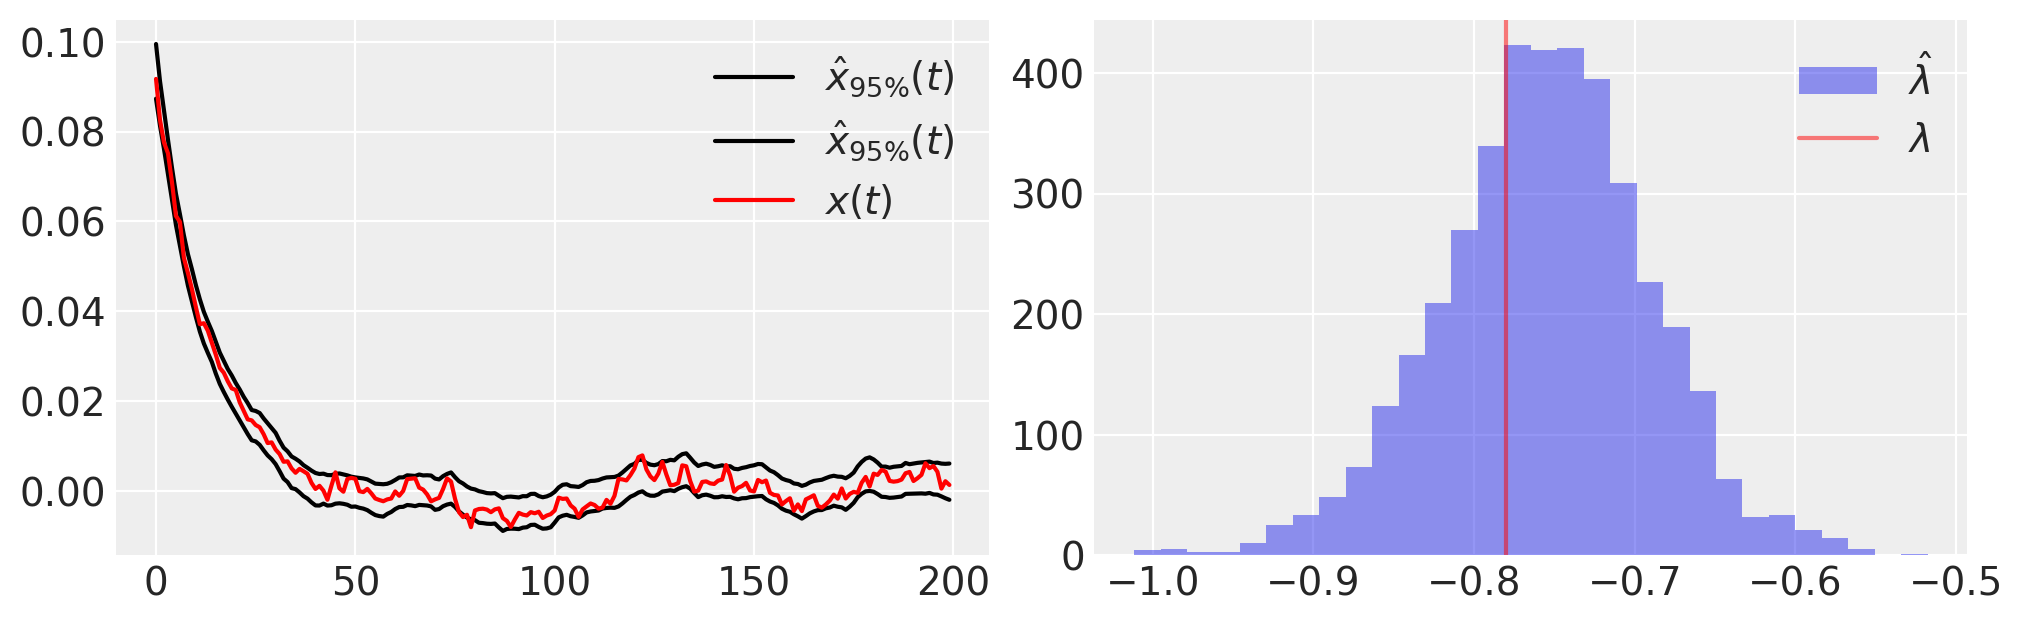

In [8]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(
    trace.posterior.quantile((0.025, 0.975), dim=("chain", "draw"))["xh"].values.T,
    "k",
    label=r"$\hat{x}_{95\%}(t)$",
)
plt.plot(x_t, "r", label="$x(t)$")
plt.legend()

plt.subplot(122)
plt.hist(-1 * az.extract(trace.posterior)["l"], 30, label=r"$\hat{\lambda}$", alpha=0.5)
plt.axvline(lam, color="r", label=r"$\lambda$", alpha=0.5)
plt.legend();

A model can fit the data precisely and still be wrong; we need to use _posterior predictive checks_ to assess if, under our fit model, the data our likely.

In other words, we 
- assume the model is correct
- simulate new observations
- check that the new observations fit with the original data

In [9]:
# generate trace from posterior
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [zh]


Output()

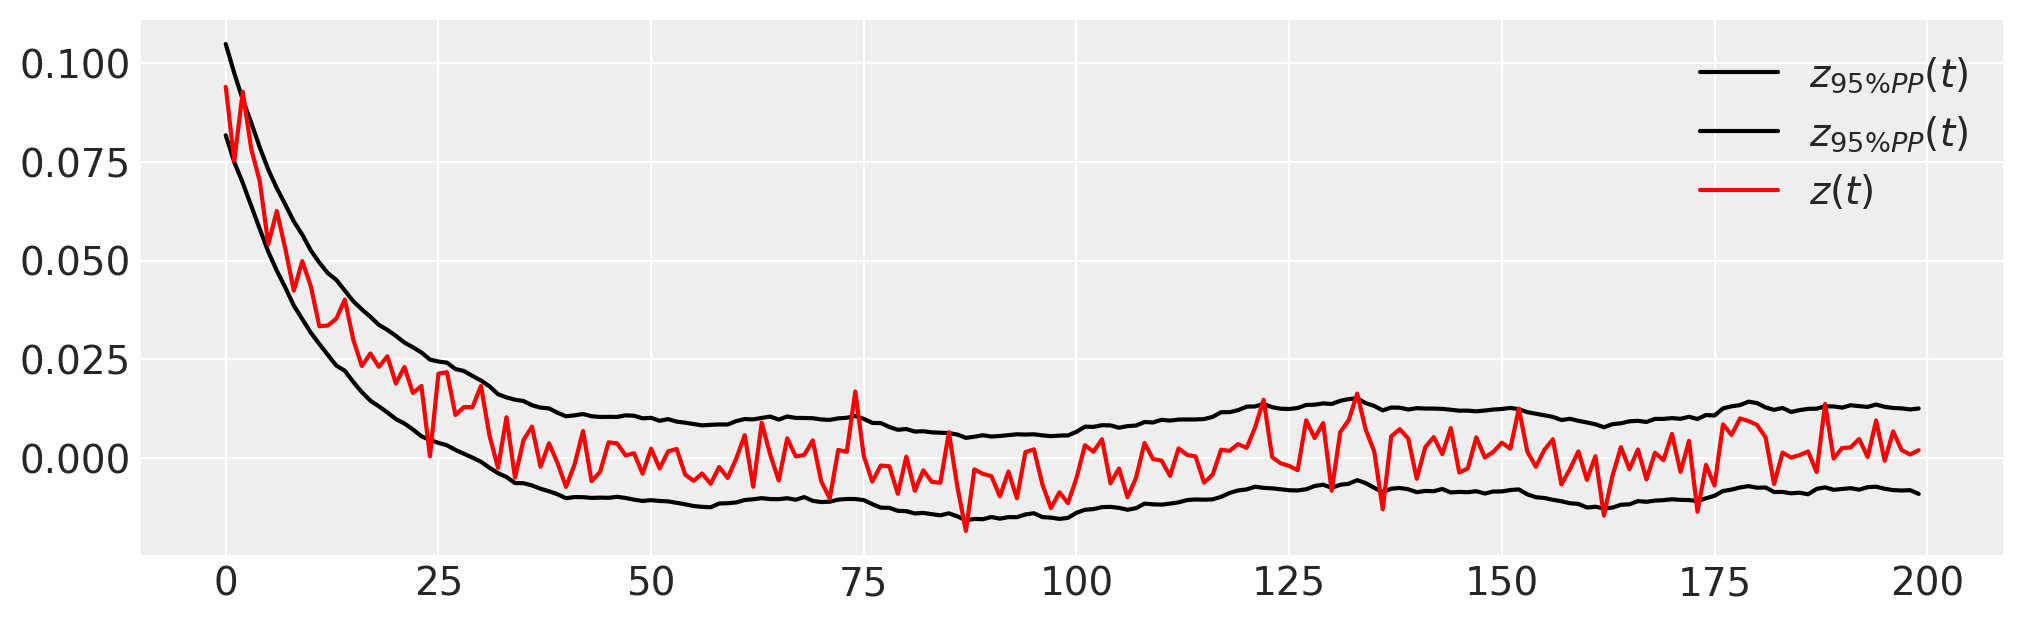

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(
    trace.posterior_predictive.quantile((0.025, 0.975), dim=("chain", "draw"))["zh"].values.T,
    "k",
    label=r"$z_{95\% PP}(t)$",
)
plt.plot(z_t, "r", label="$z(t)$")
plt.legend();

Note that the initial conditions are also estimated, and that most of the observed data $z(t)$ lies within the 95% interval of the PPC.

Another approach is to look at draws from the sampling distribution of the data relative to the observed data. This too shows a good fit across the range of observations -- the posterior predictive mean almost perfectly tracks the data.

<Axes: xlabel='zh'>

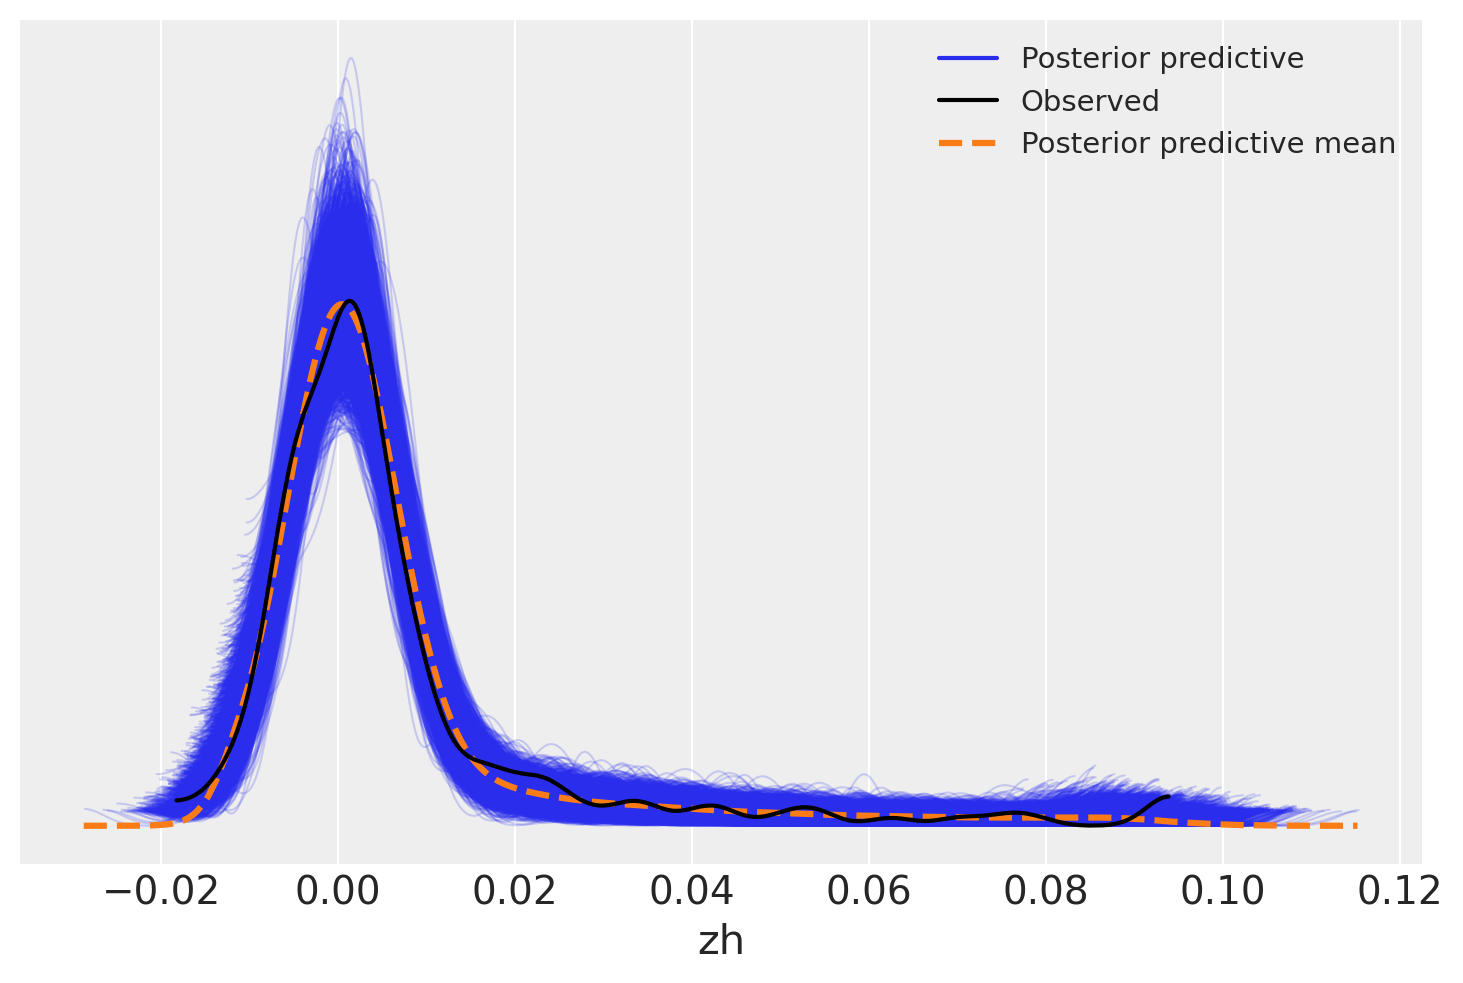

In [11]:
az.plot_ppc(trace)

## Authors
- Authored by @maedoc in July 2016
- Updated to PyMC v5 by @fonnesbeck in September 2024

## References
:::{bibliography}
:filter: docname in docnames
:::


In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 24 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

matplotlib: 3.9.2
pytensor  : 2.25.4
numpy     : 1.26.4
arviz     : 0.19.0
pymc      : 5.16.2
scipy     : 1.14.1

Watermark: 2.4.3

